# Face recognition


Весь проект можно разбить на некоторые этапы:
* считывание исходных данных (фото)
* аугментация (т.к. в test данных присутствует аугментация, и т.к. исходный train набор достаточно мал)
* применение каскадов Хаара для детекции лиц на фото
* подбор и обучение модели
* считывание test данных и детекция лиц на них (тоже каскады Хаара)
* применение модели для прогноза
* загрузка и оценка результатов

В результате применения каскадов Хаара было обнаружено, что на некоторых фото алгоритм не обнаруживает лица. Т.к. таких фото было порядка 10% на test данных, то нельзя пренебрегать ими. Было предложено разбить решение на две модели:
* первая учится(train) и прогнозирует(test) на тех данных, на которых обнаружены лица (прошли каскады)
* вторая учится на всех train данных, а прогнозирует только на тех test данных, которые не прошли каскады

Такой подход позволил обработать все test данные и составить для них прогноз

Была использована метрика accuracy, т.к. данные для тренировки были сбалансированны

Две строчки ниже подключают все библиотеки рабочего ноутбука

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import random
from scipy import stats

In [2]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [3]:
# контейнер с вариантами аугментаций
transform = A.Compose([
    A.CLAHE(),
    A.ShiftScaleRotate(shift_limit=0.0325, scale_limit=0.30, rotate_limit=25, p=0.5),
    A.Blur(blur_limit=2),
    A.GaussNoise(),
    A.HorizontalFlip()
])
random.seed(42)

In [4]:
# отрисовка фоток для визуальной проверки
def show_photos(X_array, n=10):
    fig, axx = plt.subplots(1, n, figsize=(15, 10))

    for i in range(n):
        img = X_array[i]
        axx[i].imshow(img)

In [5]:
# функция для загрузки изображений train
def get_downloading_train(dirname="ML_track_train"):
    X, y = [], []
    for fname in os.listdir(dirname):
        img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
        X.append(img)
        y.append(int(fname.split('label')[1].split('.png')[0]))

    return X, y

In [6]:
# фукция для аугментации изображений
def get_augmentation(X, y, transform=transform, n=5): 
    XAug = list()
    yAug = list()

    for (a, b) in zip(X, y):
        for i in range(n):
            XAug.append(transform(image=a)['image'])
            yAug.append(b)
    
    return XAug, yAug

*Т.к. модели будет 2 (одна для прошедших каскад Хаара, другая без него), то при применении каскадов создадим разные контейнеры для разных моделей*
* XHaar -  прошел каскад Хаара, обрезали чисто лицо
* X_Haar_on - копии прошедших Хаара, но без обрезки лиц и отложенные для модели 2
* X_not_Haar - не прошли Хаара, отложенные для модели 2

In [7]:
# функция для применения каскадов Хаара
def get_haar(XAug, yAug, cascade_type='haarcascade_frontalface_alt2.xml', trace=False):
    # прошли Хаара
    XHaar, yHaar = [], []

    # могут пройти Хаара, отложим просто для обучения модели 2
    X_Haar_on, y_Haar_on = [], []

    # не прошли Хаара
    X_not_Haar, y_not_Haar = [], []

    for (img, label) in zip(XAug, yAug):
        img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_type)
        face = face_cascade.detectMultiScale(img)
        for (a, b, w, h) in face:
            face = img[b:b + h, a:a + w]

        try:
            # это для модели_2
            X_Haar_on.append(cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA))
            y_Haar_on.append(label)
            # конец для модели_2

            h, w = face.shape
            size = min(h, w)
            h0 = int((h - size) / 2)
            w0 = int((w - size) / 2)

            img = face[h0: h0 + size, w0: w0 + size]
            img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

            XHaar.append(img)
            yHaar.append(label)

        except:
            if trace:
                print(f'no face found for {fname}')

            # это для модели_2
            X_Haar_on.pop()
            y_Haar_on.pop()

            img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
            X_not_Haar.append(img)
            y_not_Haar.append(label)
    if trace:
        'Всего данных:', len(XAug), "Загрузилось [X, y]", len(XHaar), len(yHaar)
    
    return XHaar, yHaar, X_Haar_on, y_Haar_on, X_not_Haar, y_not_Haar

In [8]:
# вспомогательная функция для упорядоченности (при загрузке тестовых данных)
def sort_by_index(fname):
    return int(fname.split('.')[0].split('image')[1])

In [9]:
# функция загрузки тестовых данных (Haar_flag=True - сразу применит каскад Хаара, по умолчанию True)
def get_downloading_test_plus_Haar(dirname="ML_track_test", Haar_flag=True, trace=False):
    # изображения, прошедшие каскады Хаара, и их названия
    Xtest, names = [], []
    
    # изображения, непрошедшие каскады Хаара, и их названия
    Xtest_not_Haar, names_not_Haar = [], []
    
    for fname in sorted(os.listdir(dirname), key=sort_by_index):
        img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE)

        if Haar_flag is True:
            img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
            face = face_cascade.detectMultiScale(img)
            for (a, b, w, h) in face:
                face = img[b:b + h, a:a + w]

        else:
            face = img

        try:
            h, w = face.shape
            size = min(h, w)
            h0 = int((h - size) / 2)
            w0 = int((w - size) / 2)

            img = face[h0: h0 + size, w0: w0 + size]
            img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

            names.append(fname)
            Xtest.append(img)

        except:
            if trace:
                print(f'no face found for {fname}')
            img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

            names_not_Haar.append(fname)
            Xtest_not_Haar.append(img)

    # визуальный контроль подгрузки 
    if trace:
        len(Xtest[0]), len(Xtest[1]), len(Xtest_not_Haar[0]), len(Xtest_not_Haar[1])
    
    return Xtest, names, Xtest_not_Haar, names_not_Haar

*Создадим функцию, которая будет выдавать прогнозы для 1-ой и 2-ой моделей (сделаем из нее аналог ансамбля случайного леса)*

In [10]:
def get_predict_random_SVC(X_TRAIN, y_TRAIN, X_VAL, estimator, n_models=30):
    # список прогнозов всех моделей
    y_PRED = list()
    # итоговый список с классами (результат голосования всех моделей)
    y_obsch = list()

    for _ in range(n_models):
        X_train, X_test, y_train, y_test = train_test_split(X_TRAIN, y_TRAIN, test_size=random.uniform(0.4, 0.55), 
                                                        random_state=random.randint(0, 2000)) 
        estimator.fit(X_train, y_train)
        y_PRED.append(estimator.predict(X_VAL))
    
    for i in range(len(y_PRED[0])):
        y_obsch.append(stats.mode([x[i] for x in y_PRED])[0][0])
    
    return y_obsch

*Напишем функцию для сбора прогноза двух моделей и формирования итогового файла решения*

Т.к. прогноз проверялся автоматически системой на соревновании, то данная функция стала необходима с учетом того, что слияние прогнозов двух моделей даст неупорядоченный результат. Функция позволяет сохранить порядок опираясь на имена test данных.

In [11]:
def solution_to_csv(names, y_pred, names_not_Haar, y_pred_not_Haar, name_submission="submission_0.csv"):
    pred_df_1 = pd.DataFrame(list(zip(names, y_pred)), columns = ['img_name', 'pred_class'])
    pred_df_1['new_ind'] = pred_df_1['img_name'].apply(lambda x: x.split('image')[1].split('.png')[0]).astype(int)
    pred_df_1 = pred_df_1.set_index('new_ind')
                    
    pred_df_2 = pd.DataFrame(list(zip(names_not_Haar, y_pred_not_Haar)), columns = ['img_name', 'pred_class'])
    pred_df_2['new_ind'] = pred_df_2['img_name'].apply(lambda x: x.split('image')[1].split('.png')[0]).astype(int)
    pred_df_2 = pred_df_2.set_index('new_ind')
                    
    pred_df = pd.concat([pred_df_1, pred_df_2])
    pred_df = pred_df.sort_index()
    pred_df = pred_df.reset_index().drop(['new_ind'], axis=1)
    pred_df.to_csv(name_submission, index=False)

In [12]:
# загрузим данные для train
X, y = get_downloading_train()

In [13]:
# проверка длины списков с фотками
len(X), len(y)

(313, 313)

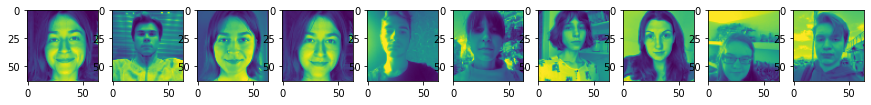

In [14]:
show_photos(X)

In [15]:
# аугментация исходных изображений
XAug, yAug = get_augmentation(X, y)

In [16]:
len(XAug)

1565

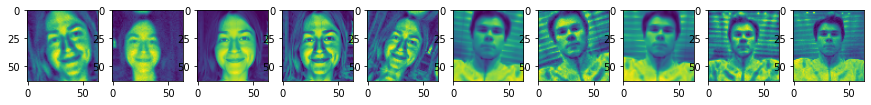

In [17]:
show_photos(XAug)

In [18]:
# склеивание аугментированных и неаугментированных данных
XAug = XAug + X
yAug = yAug + y

In [19]:
len(XAug)

1878

In [20]:
# поиск лиц на изображениях с помощью каскадов Хаара
XHaar, yHaar, X_Haar_on, y_Haar_on, X_not_Haar, y_not_Haar = get_haar(XAug, yAug)

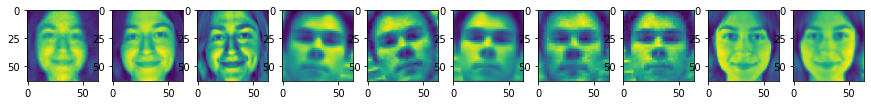

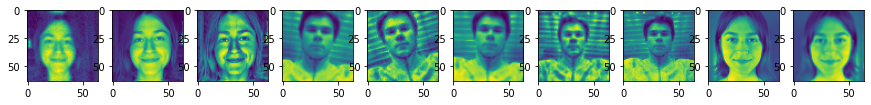

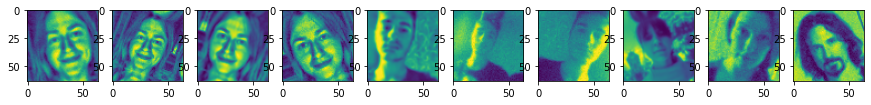

In [21]:
# вывод изображений
show_photos(XHaar)
show_photos(X_Haar_on)
show_photos(X_not_Haar)

In [22]:
# растянем в вектор
XHaar = [el.ravel() for el in XHaar]
X_not_Haar = [el.ravel() for el in X_not_Haar]
X_Haar_on = [el.ravel() for el in X_Haar_on]

In [23]:
# проверка размерности
XHaar[0].shape, X_not_Haar[0].shape, X_Haar_on[0].shape

((4096,), (4096,), (4096,))

In [24]:
# в X_m2, y_m2 положим все для обучения 2-рой модели 
X_m2 = X_not_Haar + X_Haar_on
y_m2 = y_not_Haar + y_Haar_on

*Наиболее подходящий алгоритм при решении данной задачи без использования нейросетей - SVC() (и теоретически, и экспериментально подтвердилось). Подберем его гиперпараметры с помощью поиска по сетке*

In [25]:
parametrs =  {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10]}
svc = SVC()
gcv = GridSearchCV(svc, parametrs, cv=5, n_jobs=-1)
gcv.fit(XHaar, yHaar)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'kernel': ('linear', 'rbf', 'poly')})

In [26]:
# выведем топ-5 по скору
pd.DataFrame(gcv.cv_results_)[['mean_test_score', 'param_C', 'param_kernel', 'params', \
                               'split0_test_score', 'split1_test_score', 'split2_test_score', \
                               'split3_test_score', 'split4_test_score', 'rank_test_score']] \
                                .sort_values(by='rank_test_score').reset_index().head(5)

,index,mean_test_score,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,rank_test_score
0,7,0.911748,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.915033,0.934641,0.888889,0.846405,0.973770,1
1,4,0.911094,5,rbf,"{'C': 5, 'kernel': 'rbf'}",0.915033,0.934641,0.888889,0.843137,0.973770,2
2,2,0.879698,1,poly,"{'C': 1, 'kernel': 'poly'}",0.862745,0.895425,0.882353,0.820261,0.937705,3
3,5,0.879044,5,poly,"{'C': 5, 'kernel': 'poly'}",0.862745,0.888889,0.882353,0.823529,0.937705,4
4,8,0.879044,10,poly,"{'C': 10, 'kernel': 'poly'}",0.862745,0.888889,0.882353,0.823529,0.937705,4


In [27]:
# параметры и скор первой модели
gcv.best_params_, gcv.best_score_

({'C': 10, 'kernel': 'rbf'}, 0.9117475624129433)

*Аналогично сделаем и для второй модели*

In [28]:
parametrs =  {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10]}
svc = SVC()
gcv = GridSearchCV(svc, parametrs, cv=5, n_jobs=-1)
gcv.fit(X_m2, y_m2)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'kernel': ('linear', 'rbf', 'poly')})

In [29]:
pd.DataFrame(gcv.cv_results_)[['mean_test_score', 'param_C', 'param_kernel', 'params', \
                               'split0_test_score', 'split1_test_score', 'split2_test_score', \
                               'split3_test_score', 'split4_test_score', 'rank_test_score']] \
                                .sort_values(by='rank_test_score').reset_index().head(5)

,index,mean_test_score,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,rank_test_score
0,4,0.762552,5,rbf,"{'C': 5, 'kernel': 'rbf'}",0.672872,0.771277,0.771277,0.728000,0.869333,1
1,7,0.762552,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.672872,0.771277,0.771277,0.728000,0.869333,1
2,1,0.707174,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.630319,0.712766,0.704787,0.656000,0.832000,3
3,5,0.686963,5,poly,"{'C': 5, 'kernel': 'poly'}",0.561170,0.675532,0.707447,0.661333,0.829333,4
4,8,0.686963,10,poly,"{'C': 10, 'kernel': 'poly'}",0.561170,0.675532,0.707447,0.661333,0.829333,4


In [30]:
# параметры и скор второй модели
gcv.best_params_, gcv.best_score_

({'C': 5, 'kernel': 'rbf'}, 0.7625517730496455)

**Загрузим тестовые данные (для прогноза и выгрузки ответов)**


In [31]:
# загрузим данные и сразу применим каскады Хаара
Xtest, names, Xtest_not_Haar, names_not_Haar = get_downloading_test_plus_Haar()

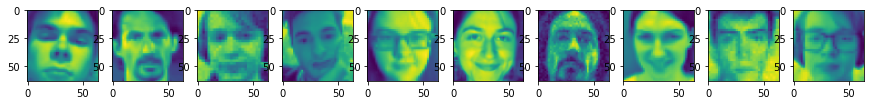

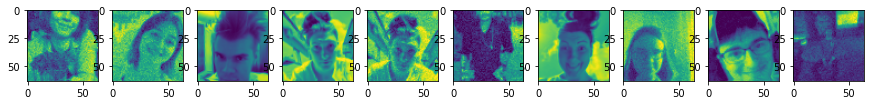

In [32]:
# визуальная проверка данных
show_photos(Xtest)
show_photos(Xtest_not_Haar)

In [33]:
len(Xtest), len(Xtest_not_Haar)

(1871, 219)

In [34]:
# растягиваем в вектор
Xtest = np.asarray([el.ravel() for el in Xtest])
Xtest_not_Haar = np.asarray([el.ravel() for el in Xtest_not_Haar])

In [35]:
len(Xtest), Xtest[0].shape

(1871, (4096,))

**Для улучшения качества модели в результате проведенных экспериментов было предпринято решение использовать не отдельную модель, а аналог ансамбля** (мажоритарное голосование)

In [36]:
# предсказания от модель_1
y_pred = get_predict_random_SVC(XHaar, yHaar, Xtest, SVC(kernel='rbf', C=10), n_models=50)

In [ ]:
# предсказания от модель_2
y_pred_not_Haar = get_predict_random_SVC(X_m2, y_m2, Xtest_not_Haar, SVC(kernel='rbf', C=5), n_models=55)

**Сбор в один Pandas DataFrame**

In [ ]:
solution_to_csv(names, y_pred, names_not_Haar, y_pred_not_Haar, name_submission='submission_1.csv')

In [ ]:
# просмотр файла решения
pd.read_csv('submission_1.csv')

Предложения по дальнейшей модернизации:
* использовать снижение размерности при помощи PCA (к примеру)
* использовать другие алгоритмы детекции лиц
* 